In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
version = '04'

In [2]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)
        
def save_history(history_t, version):
    with open(f'../model_data/history_{version}.pkl', 'wb') as handle:
        pickle.dump(history_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Dataset loading

In [3]:
right = pd.read_csv("../data/right.txt", header=None).values.tolist()
left = pd.read_csv("../data/left.txt", header=None).values.tolist()

## Pre-processing

In [4]:
batch_size = 200
batch_right = [right[i:i + batch_size] for i in range(0, len(right), batch_size)]
batch_left = [left[i:i + batch_size] for i in range(0, len(left), batch_size)]

X = np.array(batch_right + batch_left)
y = np.array([0]*len(batch_right) + [1]*len(batch_left))

In [5]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (600, 200, 2)
y shape: (600,)


In [6]:
X_diff = X[:,:-1,:].copy()
X_diff[:,:,0] = np.diff(X[:,:,0])
X_diff[:,:,1] = np.diff(X[:,:,1])

Text(0.5, 0, 'y relative movement (px)')

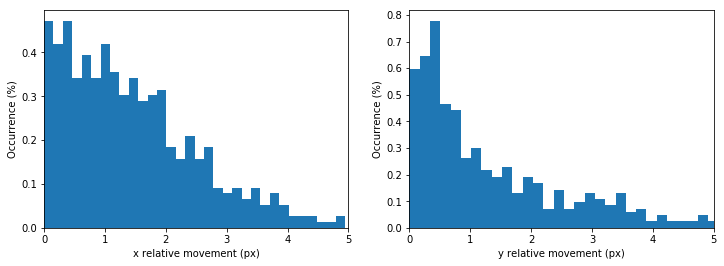

In [7]:
sigma_x = np.std(X_diff[:,:,0], axis=1)
sigma_y = np.std(X_diff[:,:,1], axis=1)
mask = (sigma_x>0.1)*(sigma_y>0.1)

X_filt = X_diff[mask]
y_filt = y[mask]

x_std = 3.398 # np.mean(np.std(X_filt[:,:,0], axis=1))
y_std = 2.926 # np.mean(np.std(X_filt[:,:,1], axis=1))

X_filt[:,:,0] = X_filt[:,:,0] / x_std
X_filt[:,:,1] = X_filt[:,:,1] / y_std

sigma_x_filt = np.std(X_filt[:,:,0], axis=1)
sigma_y_filt = np.std(X_filt[:,:,1], axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
ax1.hist(sigma_x_filt, bins=50, density=True)
ax2.hist(sigma_y_filt, bins=50, density=True)
for ax in (ax1,ax2):
    ax.set_xlim(0,5)
    ax.set_ylabel('Occurrence (%)')
    #ax.set_yticks(np.arange(0,0.41,0.1))
ax1.set_xlabel('x relative movement (px)')
ax2.set_xlabel('y relative movement (px)')

#fig.savefig(f'../plots/relative_movement_hist_corrected.png', bbox_inches='tight')

In [8]:
np.mean(np.std(X_filt[:,:,0], axis=1))

1.4900517595356684

## Training/dev/test set splitting

In [20]:
def create_train_dev_test(X, y, seed=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed, shuffle=True)
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, shuffle=True)
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = create_train_dev_test(X_filt, y_filt, seed=1)

## Model definition

In [29]:
def create_model():
    model = Sequential()
    model.add(LSTM(256, input_shape=(X_dev.shape[1], 2)))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


## Training

In [32]:
X_train, X_dev, X_test, y_train, y_dev, y_test = create_train_dev_test(X_filt, y_filt, seed=1)
adam = Adam(lr=0.001)
chk = ModelCheckpoint(f'../models/best_model_{version}.pkl', monitor='acc', save_best_only=True, mode='max', verbose=0) #monitor='val_acc'
weights = model.get_weights()
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history_t = model.fit(X_train, y_train, epochs=200, batch_size=64,
                                                callbacks=[chk], validation_data=(X_dev, y_dev))
model.set_weights(weights)

play_bell()

Train on 345 samples, validate on 74 samples
Epoch 1/200
345/345 [==============================] - 3s 8ms/step - loss: 0.6878 - acc: 0.5101 - val_loss: 0.7121 - val_acc: 0.4459
Epoch 2/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6692 - acc: 0.5362 - val_loss: 0.7288 - val_acc: 0.4189
Epoch 3/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6643 - acc: 0.5536 - val_loss: 0.7407 - val_acc: 0.4324
Epoch 4/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6509 - acc: 0.5710 - val_loss: 0.7300 - val_acc: 0.4324
Epoch 5/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6504 - acc: 0.5710 - val_loss: 0.7306 - val_acc: 0.4595
Epoch 6/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6440 - acc: 0.5594 - val_loss: 0.7356 - val_acc: 0.4324
Epoch 7/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6369 - acc: 0.5710 - val_loss: 0.7485 - val_acc: 0.4324
Epoch 8/200
345/345 [===

Epoch 62/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6347 - acc: 0.5942 - val_loss: 0.6690 - val_acc: 0.6351
Epoch 63/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6365 - acc: 0.5681 - val_loss: 0.7332 - val_acc: 0.5811
Epoch 64/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6437 - acc: 0.5681 - val_loss: 0.7964 - val_acc: 0.4865
Epoch 65/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6459 - acc: 0.5594 - val_loss: 0.7968 - val_acc: 0.4595
Epoch 66/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6275 - acc: 0.5971 - val_loss: 0.7814 - val_acc: 0.5676
Epoch 67/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6227 - acc: 0.5652 - val_loss: 0.7682 - val_acc: 0.5541
Epoch 68/200
345/345 [==============================] - 2s 5ms/step - loss: 0.6218 - acc: 0.5739 - val_loss: 0.7563 - val_acc: 0.5811
Epoch 69/200
345/345 [==============================] - 2s 5ms

Epoch 123/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6384 - acc: 0.5449 - val_loss: 0.7542 - val_acc: 0.5811
Epoch 124/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6332 - acc: 0.5942 - val_loss: 0.7539 - val_acc: 0.5541
Epoch 125/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6295 - acc: 0.5884 - val_loss: 0.7490 - val_acc: 0.5405
Epoch 126/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6242 - acc: 0.5855 - val_loss: 0.7401 - val_acc: 0.5541
Epoch 127/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6278 - acc: 0.5797 - val_loss: 0.7218 - val_acc: 0.5541
Epoch 128/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6231 - acc: 0.6116 - val_loss: 0.7217 - val_acc: 0.4865
Epoch 129/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6223 - acc: 0.5942 - val_loss: 0.7117 - val_acc: 0.5946
Epoch 130/200
345/345 [==============================] 

345/345 [==============================] - 2s 6ms/step - loss: 0.5040 - acc: 0.7043 - val_loss: 0.8296 - val_acc: 0.5946
Epoch 184/200
345/345 [==============================] - 2s 6ms/step - loss: 0.4800 - acc: 0.7391 - val_loss: 0.8355 - val_acc: 0.5676
Epoch 185/200
345/345 [==============================] - 2s 6ms/step - loss: 0.4840 - acc: 0.7391 - val_loss: 0.7725 - val_acc: 0.6081
Epoch 186/200
345/345 [==============================] - 2s 7ms/step - loss: 0.5099 - acc: 0.7101 - val_loss: 0.7819 - val_acc: 0.5676
Epoch 187/200
345/345 [==============================] - 2s 7ms/step - loss: 0.4751 - acc: 0.7391 - val_loss: 0.7424 - val_acc: 0.6216
Epoch 188/200
345/345 [==============================] - 3s 10ms/step - loss: 0.4599 - acc: 0.7536 - val_loss: 0.8327 - val_acc: 0.5946
Epoch 189/200
345/345 [==============================] - 2s 7ms/step - loss: 0.4724 - acc: 0.7217 - val_loss: 0.7418 - val_acc: 0.5946
Epoch 190/200
345/345 [==============================] - 2s 7ms/step

## Training history plot

Best accuracy on the dev set: 71.6%
Best accuracy on the training set: 75.4%


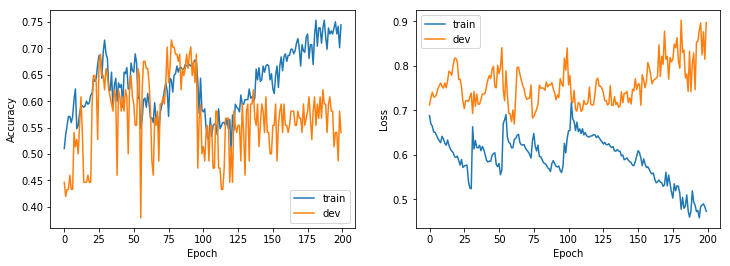

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history_t.history['acc'], label='train')
ax1.plot(history_t.history['val_acc'], label='dev')

ax2.plot(history_t.history['loss'], label='train')
ax2.plot(history_t.history['val_loss'], label='dev')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.legend()
ax2.legend()

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

best_acc = max(history_t.history['val_acc'])
print(f'Best accuracy on the dev set: {best_acc*100:.1f}%')
best_acc_training = max(history_t.history['acc'])
print(f'Best accuracy on the training set: {best_acc_training*100:.1f}%')
#fig.savefig(f'../plots/model_{version}.png', bbox_inches='tight')

## Evaluation of the model

In [34]:
model = load_model(f'../models/best_model_{version}.pkl') # load best model

In [35]:
dev_preds = model.predict_classes(X_dev)
acc_dev = accuracy_score(y_dev, dev_preds)
print(f'Accuracy on the dev set: {acc_dev*100:.1f}%')

training_preds = model.predict_classes(X_train)
acc_training = accuracy_score(y_train, training_preds)
print(f'Accuracy on the training set: {acc_training*100:.1f}%')

test_preds = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set: {acc_test*100:.1f}%')

Accuracy on the dev set: 59.5%
Accuracy on the training set: 77.4%
Accuracy on the test set: 60.8%


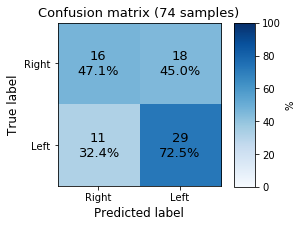

In [36]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)
#cm = confusion_matrix(y_dev, dev_preds)
#cm = confusion_matrix(y_train, training_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_dev.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

#fig.savefig(f'../plots/conf_matrix_{version}.png', bbox_inches='tight')

In [17]:
sum(y_train)/len(y_train)

0.4579710144927536